In [3]:
#!/usr/bin/env python
%matplotlib inline

## A/B testing design

Before running an A/B test to compare a new website design (labeled the B design) to the existing design (labeled A), it is a good idea to determine how many users will be needed to evaluate if the new design performs better than the old one. The t-test is an effective statistical tool to evaulate significance once the experiment is over, and there are many online tutorials explaining how to use it. I didn't find a comparable resource explaining the calculation of sample sizes, so I put together this notebook to demonstrate the (simple) steps.

### Calculating necessary sample sizes given
   
   - null hypothesis
   - expected effect size
   - false positive rate
   - false negative rate.
First, we'll import the usual Python mondules:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import scipy.stats

### Experiment Settings 

#### 1. original CTR, effective increase

Now, I'll enter some numbers to make the discussion more concrete. Imagine we have a click through rate of 5% with the original design. Call this p_a for probability(A). Suppose in addition that we decide that the click through rate must increase to at least 7% to make changing the design worthwhile. Call this p_b. Finally, we'll calculate the average click through rate, p, assuming that our sample sizes will be equal.

- p(a): a click through rate of 5% with the original design
- p(b): the click through rate must increase to 7%
- p: avergae CTR rate given the equal sample size

In [5]:
p_a = .05 # assume we have a base click rate of 5% for our original design (A group)
p_b = .07 # we want to detect an increase in click rate to 7%, otherwise not worth changing the design

p = (p_a + p_b)/2.
round(p,2)

0.06

#### 2. FP rate, FN rate

In addition to these two values, we'll need to decide on false positive and false negative rates. We can use these to look up values from the Normal distribution (results are labeled Z below). Here we chose 5% false positive rate (also called Type I error rate) and 80% power, equivalent to a 20% false negative rate (or Type II error rate). These rates are fairly standard, but completely arbitrary. These choices mean that we expect to falsely say that B is an improvement 5% of the time when actually it is no better than A, and we expect to falsely say B is *not* and improvement 20% of the time when actually it is better than A.
- Type I: FP rate (Type I Error Rate) = 5% 

    Falsely say that B is an improvement 5% of the time when actually it is no better than A
- Type II: FN rate (Type II Error Rate, 1-power) = 20%

    Falsely say B is *not* an improvement 20% of the time when actually it is better than A.

#### 3. One tail test

Only cares if the CTR increased after the change:

In [6]:
num_tails = 1

### Calculate Sample Size

**Effective Size**

$ ES =\frac{|p(b)-p(a)|}{\sqrt{p*(1-p)}} =\frac{|0.07-0.05|}{\sqrt{0.06*(1-0.06)}} $

**Sample Size**
- One-tailed: $ n = 2*(\frac{Z_{95}+Z_8}{ES})^2 = 1743$
- Two-tailed: $ n = 2*(\frac{Z_{975}+Z_8}{ES})^2 = 2213$

Ref: https://www.itl.nist.gov/div898/handbook/prc/section2/prc222.htm

In [7]:
Z8 = scipy.stats.norm.ppf(.8) # 0.84, we will need this to ensure 80% power (20% false negative rate)
Z95 = scipy.stats.norm.ppf(1 - .05) # 1.64 we will need this for 5% false positive rate (95% confidence level), one-tailed
Z975 = scipy.stats.norm.ppf(1 - .025) # 1.96 5% false positive rate for two-tailed case

ES = abs(p_b - p_a)/np.sqrt(p*(1-p))

if num_tails == 2:
    n = 2*((Z975 + Z8)/ES)**2  # two-tailed
else:
    n = 2*((Z95 + Z8)/ES)**2 # one-tailed

print(f"You need {round(n)} samples in each group to get a 5% false positive and 20% false negative rate given effect size")

You need 1743 samples in each group to get a 5% false positive and 20% false negative rate given effect size


That's it! We have the sample sizes necessary given our requirements. In this case, we need about 1743 people to experience the A design and 1743 people to experience the B design.

## Simulation Test

Let's convince ourselves that we actually meet our specs by simulating two experimental results. In one experiment the B design results in a minimal improvement (to 7% click rate). In the other (labeled null) there is no change in the click rate.

**Design**

1. For `10000` experiments(each with `1743` samples), simulate conversion results for: `(1743, 10000)`, `([[T,F,T,T...],]）`
    - Experiment A according to `p(A)`
    - Experiment B according to `p(B)`
    - Experiment B with $ N_0 $ (using `p(A)` to simulate)
2. Calculate conversion rate for each experiment (mean): `(10000,)`
    - Experiment A
    - Experiment B
    - Experiment B with $ N_0 $ 

In [8]:
n_a = int(round(n))
n_b = int(round(n))

num_experiments = 10000

# n_b = n_a = 1743
conversions_a = np.random.random((n_a, num_experiments)) < p_a
conversions_b_null = np.random.random((n_b, num_experiments)) < p_a
conversions_b = np.random.random((n_b, num_experiments)) < p_b

mean_a = np.mean(conversions_a, axis=0)
mean_b_null = np.mean(conversions_b_null, axis=0)
mean_b = np.mean(conversions_b, axis=0)

3. Calculate the standard deviation of each experiment: `(10000,)`
    - Experiment A
    - Experiment B
    - Experiment B with $ N_0 $ 
4. Calculate the standard deviation: 
    - $ SD =  \sqrt{\frac{sd_A^2}{n_A}+\frac{sd_B^2}{n_B}} $
    - $ SD_{null} =  \sqrt{\frac{sd_A^2}{n_A}+\frac{sd_{B\_null}^2}{n_{_{B\_null}}}} $

In [9]:
#s_a = np.std(conversions_a, ddof=1)
#s_b_null = np.std(conversions_b_null, ddof=1)
#s_b = np.std(conversions_b, ddof=1)

# equivalent:
s_a = np.sqrt(np.sum((conversions_a - mean_a[np.newaxis, :])**2, axis=0)/(n_a - 1))
s_b_null = np.sqrt(np.sum((conversions_b_null - mean_b_null[np.newaxis, :])**2, axis=0)/(n_b - 1))
s_b = np.sqrt(np.sum((conversions_b - mean_b[np.newaxis, :])**2, axis=0)/(n_b - 1))

sp = np.sqrt(s_a**2/n_a + s_b**2/n_b)
sp_null = np.sqrt(s_a**2/n_a + s_b_null**2/n_b)


5. Calculate the t test result
    - One-tailed: 
        - Experiment B: $ t = \frac{|\bar{b}-\bar{a}|}{SD} $
        - Null B: $ t_{null} = \frac{|\bar{b_{null}}-\bar{a}|}{SD_{null}} $
        - Results = $ t > Z_{0.95}$
        - Null Results = $ t_{null} > Z_{0.95}$
    - Two-tailed:
        - Experiment B: $ t = \frac{|\bar{b}-\bar{a}|}{SD} $
        - Null B: $ t_{null} = \frac{|\bar{b_{null}}-\bar{a}|}{SD_{null}} $
        - Results = $ t > Z_{0.975}$
        - Null Results = $ t_{null} > Z_{0.975}$

6. Calculate error rate:
    - FN rate = 1 - results rate
    - FP rate = null rseults rate 

In [10]:
if num_tails == 2:
    t = abs(mean_b - mean_a) / sp # two-tailed
    t_null = abs(mean_b_null - mean_a) / sp_null # two-tailed
    results = t > Z975  # two-tailed
    results_null = t_null > Z975  # two-tailed
else:
    t = (mean_b - mean_a) / sp # one-tailed
    t_null = (mean_b_null - mean_a) / sp_null # one-tailed
    results = t > Z95 # one-tailed
    results_null = t_null > Z95 # one-tailed

false_negative_rate = 1 - np.sum(results).astype('float')/len(results)
false_positive_rate = np.sum(results_null).astype('float')/len(results_null)

print(f"{round(false_negative_rate,4)} false negative rate, we expect it to be close to 20%")
print(f"{round(false_positive_rate,4)} false positive rate, we expect it to be close to 5%")

0.1961 false negative rate, we expect it to be close to 20%
0.0486 false positive rate, we expect it to be close to 5%


#### Plot

And finally, I'll plot the results of the simulated experiments:

Text(0.016, 100, '5% false positives')

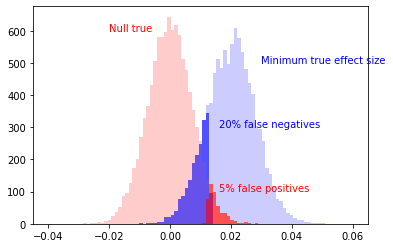

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

n, bins, p = ax.hist(mean_b - mean_a, np.linspace(-.04, .06, 88), color=[.8, .8, 1])
n, bins, p = ax.hist(mean_b_null - mean_a, bins, color=[1, .8, .8])

n, bins, p = ax.hist(mean_b[results==False] - mean_a[results==False], bins, color='b', alpha=.6)
n, bins, p = ax.hist(mean_b_null[results_null] - mean_a[results_null], bins, color='r', alpha=.6)

ax.text(-.02, 600, 'Null true', color='r')
ax.text(.03, 500, 'Minimum true effect size', color='b')

ax.text(.016, 300, str(round(false_negative_rate*100))+"% false negatives", color='b')
ax.text(.016, 100, str(round(false_positive_rate*100))+"% false positives", color='r')

We can see that we achieve exactly the false positive and false negative rates we set out for in the two different simuluated experiments.